# Import necessary libraries

In [1]:
!pip install scikit-image


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
import matplotlib.pyplot as plt


# Define Data Paths

In [3]:
train_images_path = 'cityscapes_data/train'
val_images_path = 'cityscapes_data/val'


# Load and preprocess the data

* Since, we have no label folders in this dataset, so we will not be able to use Unet cnn architecture model , as it is a supervised learninfg model, it requires labels of the corresponding images.
* In order to use unet, we will generate synthetic labels for all the images.

In [4]:
def image_generator(image_folder, batch_size, image_size=(256, 256)):
    image_files = os.listdir(image_folder)
    while True:
        for start in range(0, len(image_files), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_files))
            ids_batch = image_files[start:end]
            for id in ids_batch:
                img = imread(os.path.join(image_folder, id))
                img = resize(img, image_size, mode='constant', preserve_range=True)
                x_batch.append(img)
                
                # Generate dummy labels
                label = np.zeros_like(img)
                y_batch.append(label)
                
            x_batch = np.array(x_batch) / 255.0
            y_batch = np.array(y_batch) / 255.0
            yield x_batch, y_batch

batch_size = 8
train_generator = image_generator(train_images_path, batch_size)
val_generator = image_generator(val_images_path, batch_size)


In [5]:
from tensorflow.keras.layers import Dropout

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(drop1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(drop2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(drop3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(drop4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(drop5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Data Augmentation

* It can help improve model performance by providing more varied data

In [6]:
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def augment_data(image_generator, mask_generator, batch_size):
    return zip(image_generator, mask_generator)

train_image_generator = image_datagen.flow_from_directory(train_images_path, target_size=(256, 256), class_mode=None, batch_size=batch_size, seed=1)
train_mask_generator = mask_datagen.flow_from_directory(train_images_path, target_size=(256, 256), class_mode=None, batch_size=batch_size, seed=1)
train_generator = augment_data(train_image_generator, train_mask_generator, batch_size)

val_image_generator = image_datagen.flow_from_directory(val_images_path, target_size=(256, 256), class_mode=None, batch_size=batch_size, seed=1)
val_mask_generator = mask_datagen.flow_from_directory(val_images_path, target_size=(256, 256), class_mode=None, batch_size=batch_size, seed=1)
val_generator = augment_data(val_image_generator, val_mask_generator, batch_size)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


# Train the model

In [9]:
checkpoint = ModelCheckpoint('unet_cityscapes.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(train_generator,
                    steps_per_epoch=len(os.listdir(train_images_path)) // batch_size,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(os.listdir(val_images_path)) // batch_size,
                    callbacks=[checkpoint, early_stopping])


Epoch 1/10
371/371 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.00000, saving model to unet_cityscapes.h5
371/371 [==============================] - 139s 374ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
371/371 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.00000
371/371 [==============================] - 139s 376ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
371/371 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 3: val_loss did not improve from 0.00000
371/371 [==============================] - 141s 381ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
371/371 [==============================] - ETA:

# Evaluate the model

In [10]:
from skimage.transform import resize

In [11]:
# Generate dummy validation data for evaluation (replace with actual data when available)
val_images = np.array([resize(imread(os.path.join(val_images_path, file)), (256, 256), mode='constant', preserve_range=True) for file in os.listdir(val_images_path)]) / 255.0
val_labels = np.zeros_like(val_images)  # Replace with actual labels when available

loss, accuracy = model.evaluate(val_images, val_labels)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


16/16 [==============================] - 166s 10s/step - loss: 0.6805 - accuracy: 0.9921
Validation Loss: 0.6804660558700562
Validation Accuracy: 0.9920607209205627


# Visualise the results

1/1 [==============================] - 0s 319ms/step


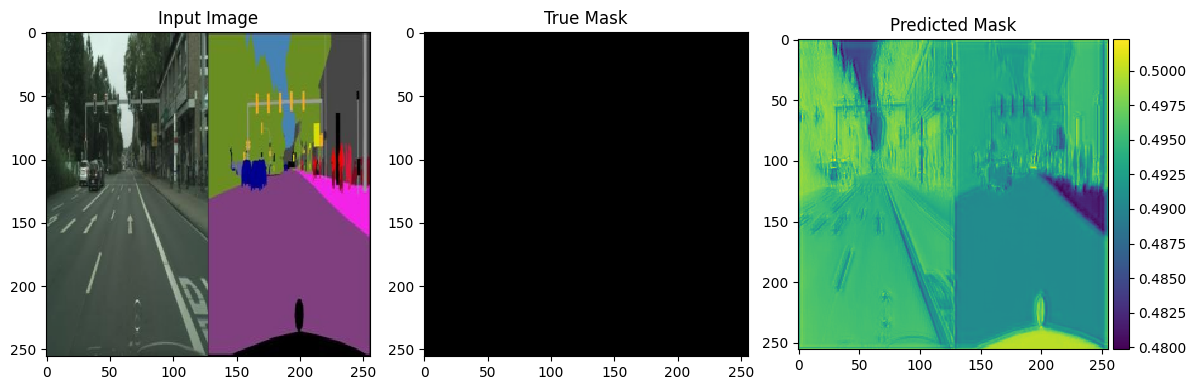

1/1 [==============================] - 0s 345ms/step


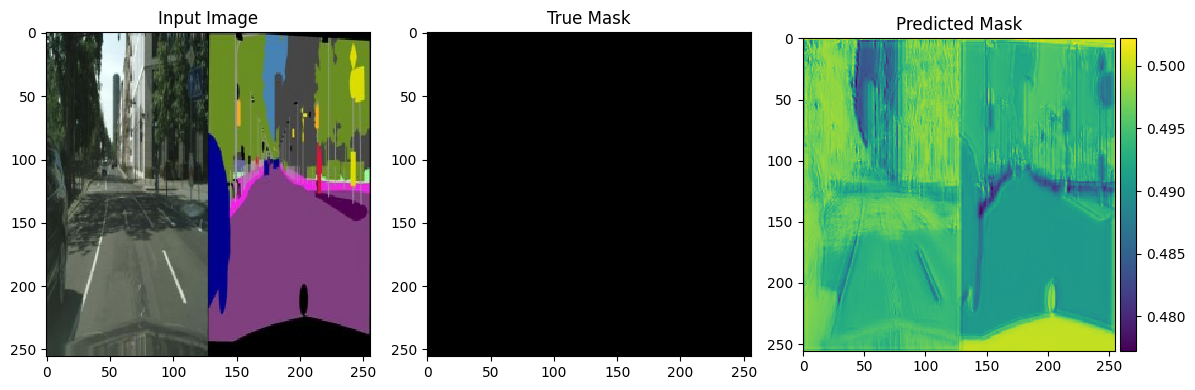

1/1 [==============================] - 0s 342ms/step


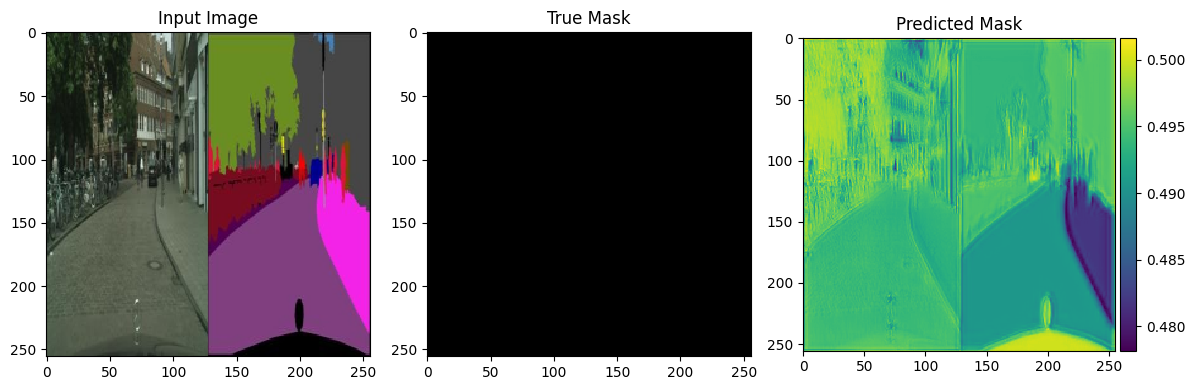

1/1 [==============================] - 0s 320ms/step


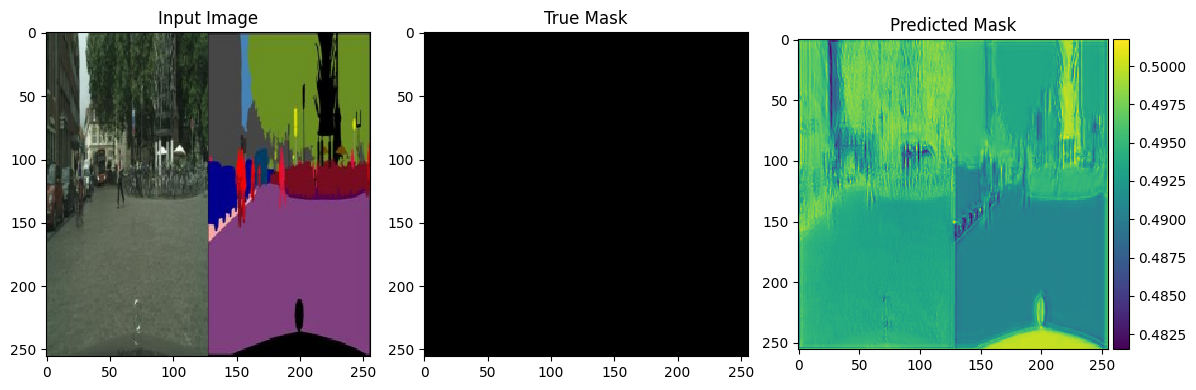

1/1 [==============================] - 0s 393ms/step


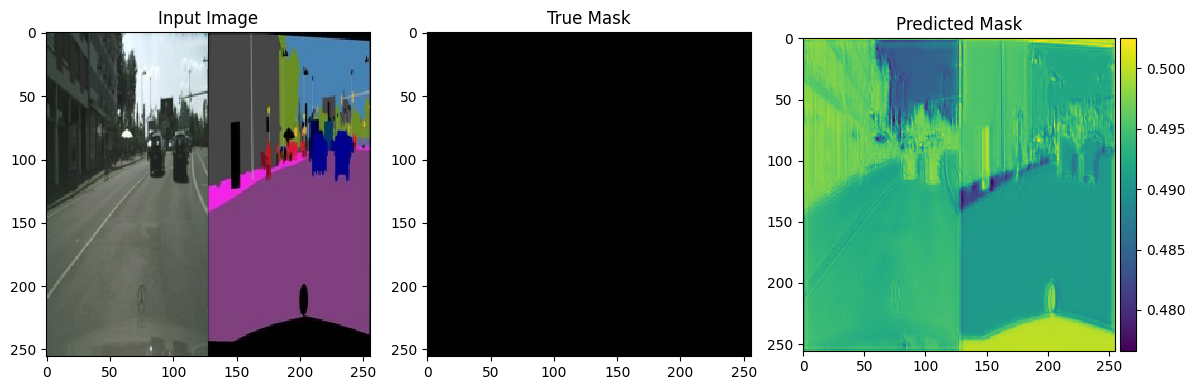

1/1 [==============================] - 0s 371ms/step


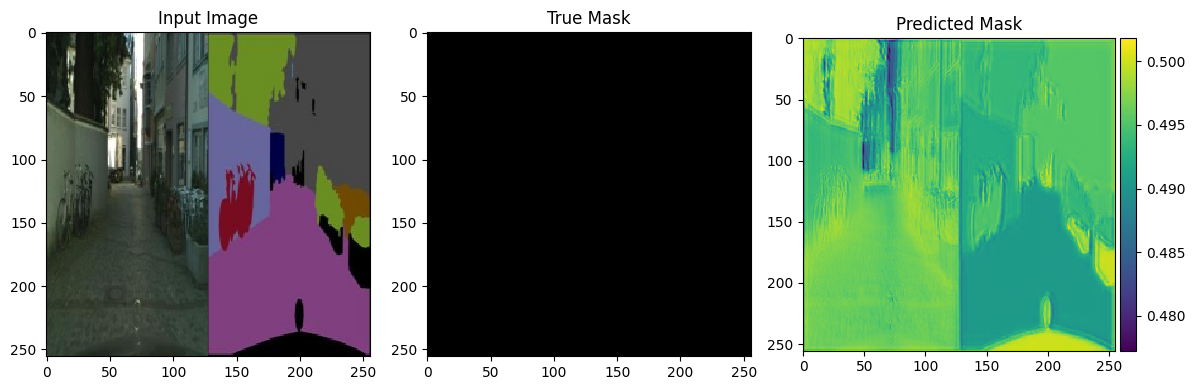

1/1 [==============================] - 0s 359ms/step


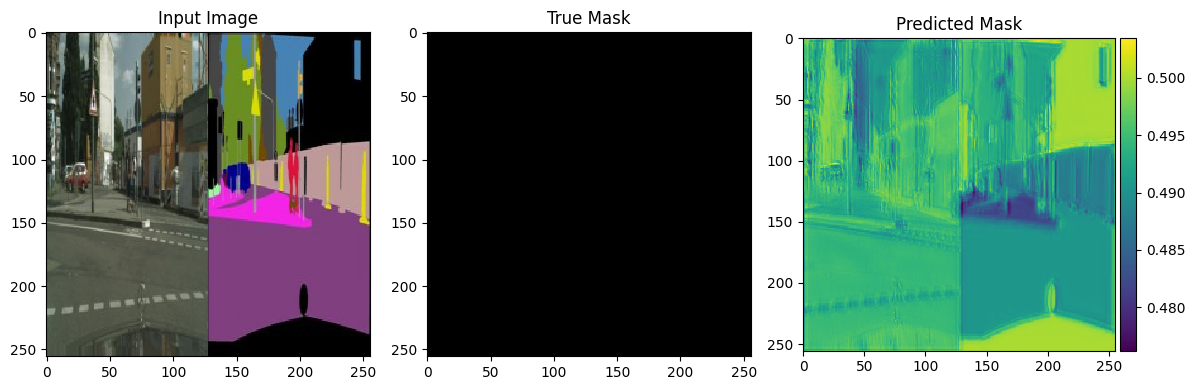

1/1 [==============================] - 0s 355ms/step


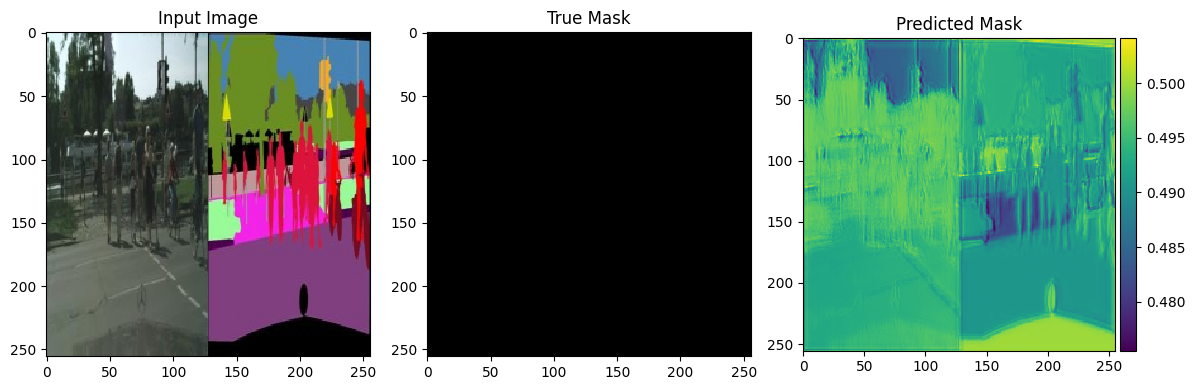

1/1 [==============================] - 0s 396ms/step


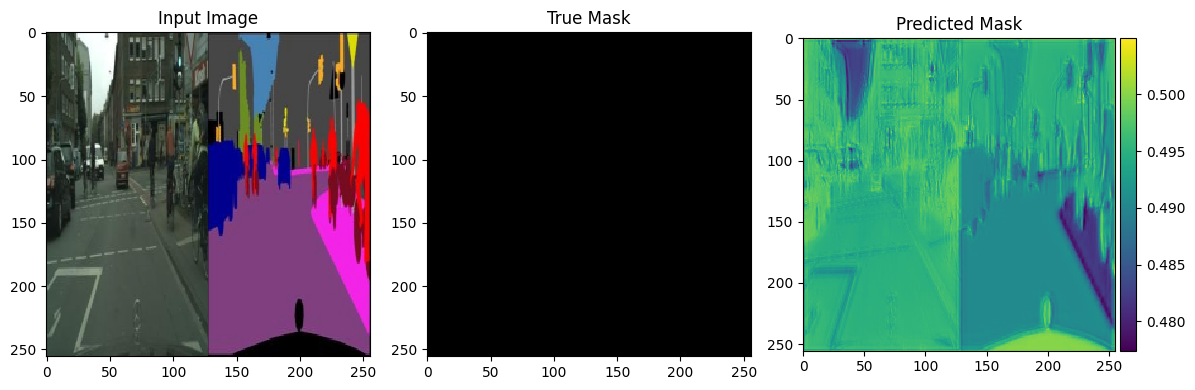

1/1 [==============================] - 0s 371ms/step


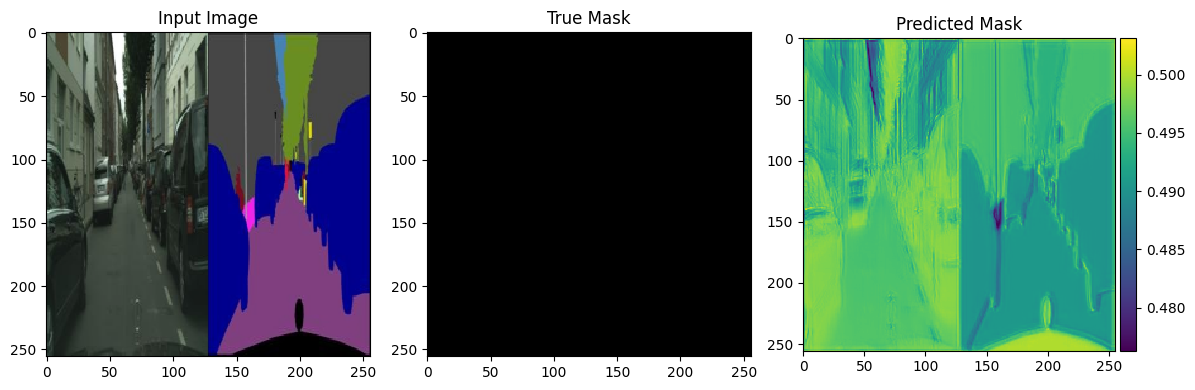

1/1 [==============================] - 0s 360ms/step


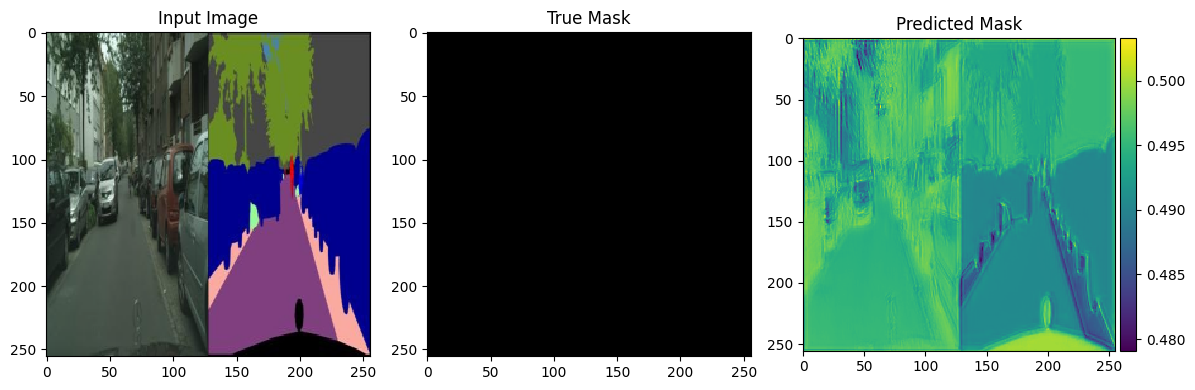

1/1 [==============================] - 0s 385ms/step


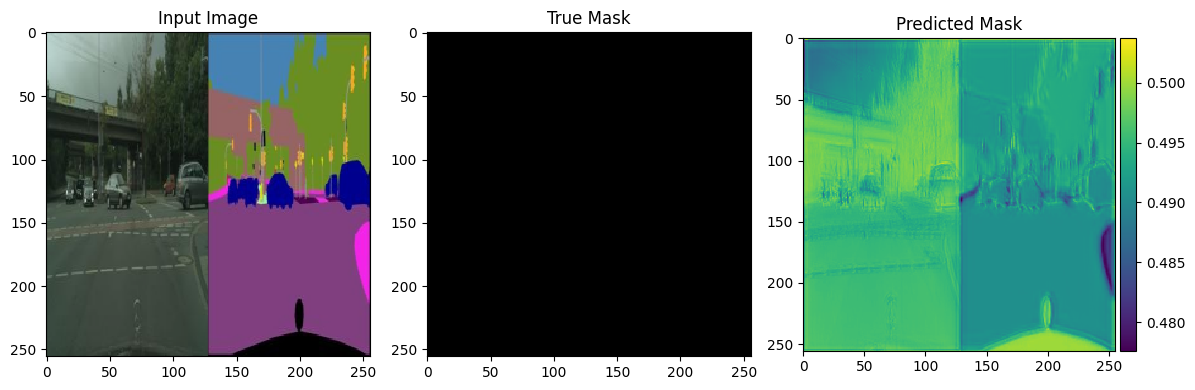

1/1 [==============================] - 0s 412ms/step


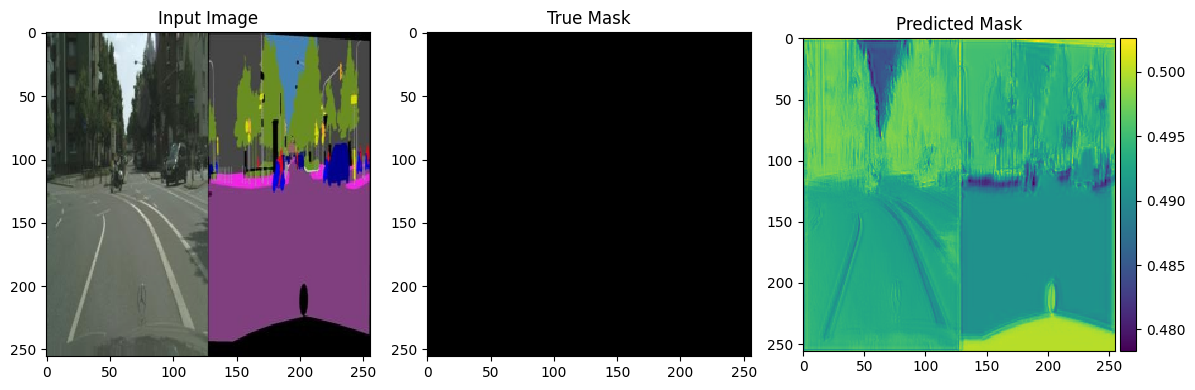

1/1 [==============================] - 0s 391ms/step


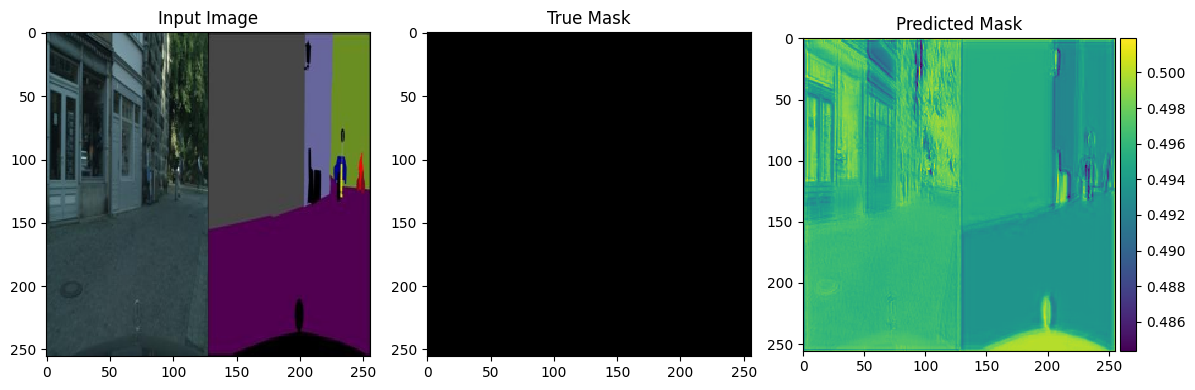

1/1 [==============================] - 0s 327ms/step


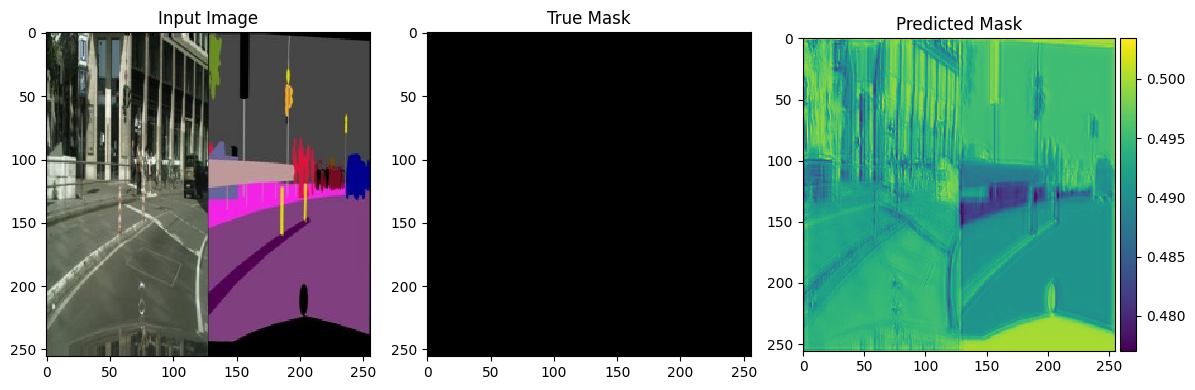

1/1 [==============================] - 0s 393ms/step


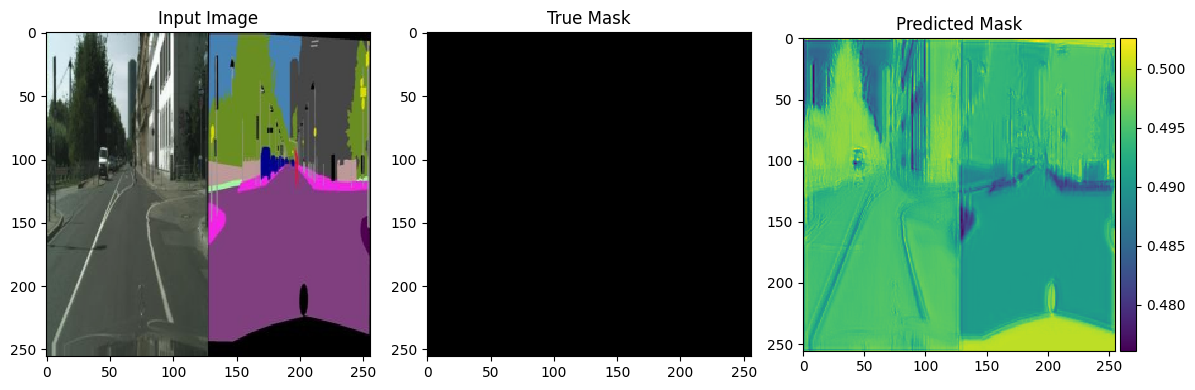

1/1 [==============================] - 0s 358ms/step


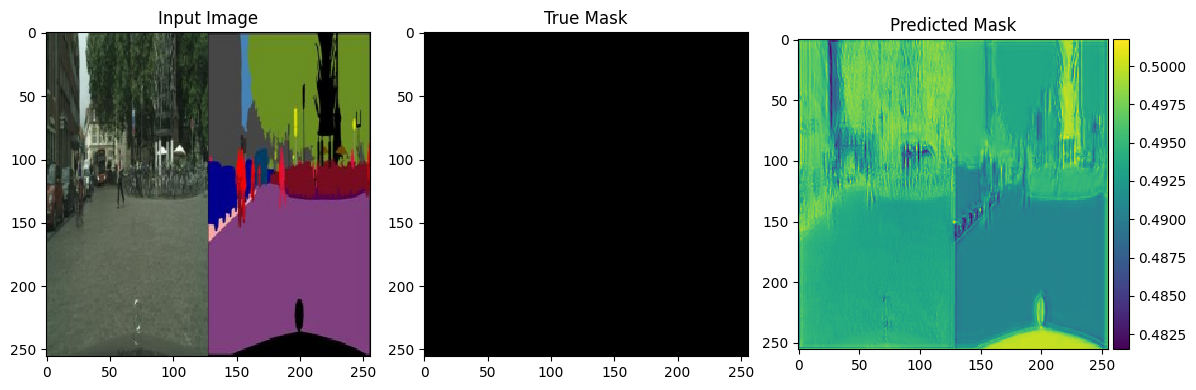

1/1 [==============================] - 0s 334ms/step


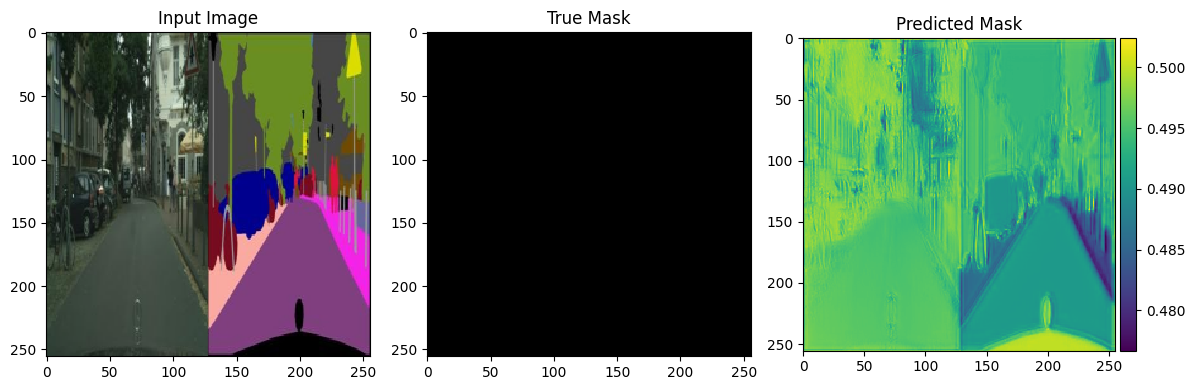

1/1 [==============================] - 0s 364ms/step


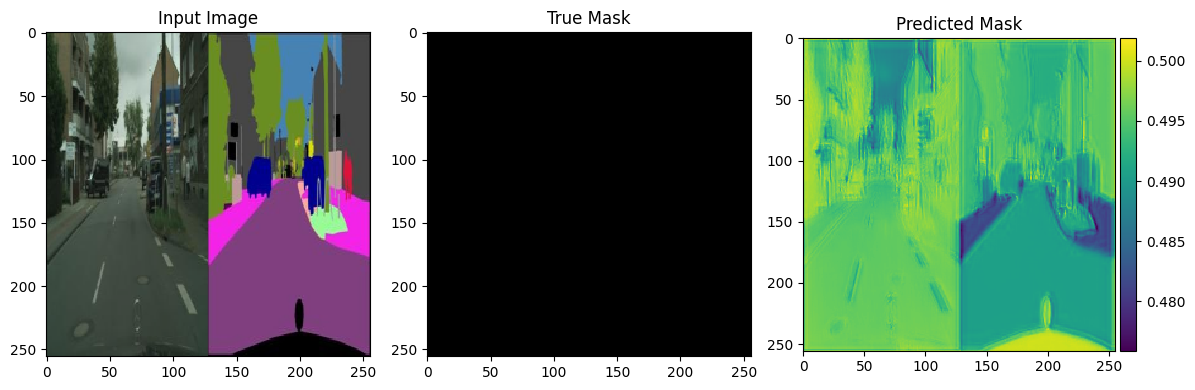

1/1 [==============================] - 0s 349ms/step


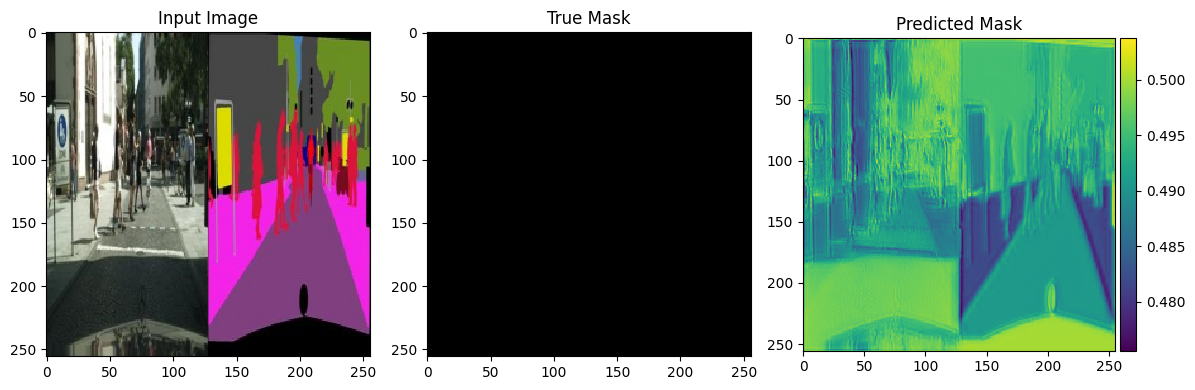

In [15]:
def plot_sample(image, mask, prediction):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    imshow(mask)
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    imshow(prediction)
    plt.show()

for i in range(20):
    index = np.random.randint(0, len(val_images))
    image = val_images[index]
    mask = val_labels[index]
    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    plot_sample(image, mask, prediction)
